In [16]:
import numpy as np
from numba import njit
import time
from joblib import Parallel, delayed
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_setup():
    plt.rcParams['text.usetex'] = False
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    plt.rcParams['mathtext.fontset'] = 'cm'
    # plt.rcParams['figure.autolayout'] = 'True'

    sns.set_style('ticks',{'axes.edgecolor': '[0,0,0]',
                           'xtick.direction':'in',
                           'ytick.direction':'in',
                           'ytick.right':'True',
                           'xtick.top':'True',
                           'xtick.color':'k',
                           'ytick.color':'k'
                            })

# def calc_msd(r):
#     #https://stackoverflow.com/questions/34222272/computing-mean-square-displacement-using-python-and-fft
#     #r needs to be columns
#     shifts = np.arange(len(r))
#     msds = np.zeros(shifts.size)
#     for i, shift in enumerate(shifts):
#         diffs = r[:-shift if shift else None] - r[shift:]
#         sqdist = np.square(diffs).sum(axis=1)
#         msds[i] = sqdist.mean()
#     return msds    
    
@njit()
def diffusion(size,sigma,mu):
    gamma_m = 6*np.pi*mu*0.01
    gamma = 6*np.pi*mu*0.005*size
    return ((sigma/(gamma_m+gamma))**2)/2

@njit()
def diffusion_fluid_drag(size,sigma,mu):
    gamma_m = 6*np.pi*0.3*0.01
    gamma = 6*np.pi*mu*0.005*size
    return ((sigma/(gamma_m+gamma))**2)/2

@njit()
def velocity_fluid_drag(size,mu):
    a = 0.005*size
    gamma_m = 6*np.pi*0.3*0.01
    return (6*np.pi*mu*a)/(gamma_m + 6*np.pi*mu*a)

@njit()
def Pe(r,vc):
    return np.sqrt(np.dot(vc,vc))/np.sqrt(np.dot(r-vc,r-vc))

@njit()
def Sp(r,vc):
    return np.dot(r,vc)/np.sqrt(np.dot(vc,vc))

@njit()
def Co(r,vc):
    return (np.dot(r,vc)/np.sqrt(np.dot(vc,vc)))/np.sqrt(np.dot(r,r))

@njit()
def plus(n,kplus,dt):
    return kplus*dt

@njit()
def minus(n,kminus,dt):
    return kminus*dt

@njit()
def on(n,kon0,kon1,dt):
    return (kon0+kon1*(n-1))*dt

@njit()
def off(n,koff0,koff1,dt):
    return koff0*dt

@njit()
def Model1ABM(sigma,mu,num):
    #
    # Set up parameters
    #
    x0 = 0
    y0 = 0
    t0 = 0
    tend = num
    dt = 0.001
    tgrid = np.arange(t0,tend+dt,dt)
    kplus = 0.05
    kminus = 0.1
    kon0 = 0
    kon1 = 0
    koff0 = 0
    koff1 = 0
    m = 2
    vc = np.zeros(m)
    vc[0] = 0
    #
    # Set up initial condtions, and initialize storage vectors
    #
    x = np.empty(tgrid.size)
    y = np.empty(tgrid.size)
    x[0] = x0
    y[0] = y0
    n = np.empty(tgrid.size)
    n[0] = 10 # np.random.randint(low=1,high=(10+1)) #random size between 1 and 10 at t0
    b = np.empty(tgrid.size)
    b[0] = 0
    #
    # time loop
    #
    for i in range(1,tgrid.size):
        #update diffusion
        D = 0.001
        #update position
        x[i] = x[i-1] + vc[0]*dt + np.sqrt(2*D*dt)*np.random.randn()
        y[i] = y[i-1] + vc[1]*dt + np.sqrt(2*D*dt)*np.random.randn()
        #
        # Calculate reaction probabilities
        # (calls functions for the size dependent reaction rates)
        #
        probs = np.array([plus(n[i-1],kplus,dt),
                          minus(n[i-1],kminus,dt),
                          on(n[i-1],kon0,kon1,dt),
                          off(n[i-1],koff0,koff1,dt)])
        # vector of probabilities
        # these reactions are thus indexed by rxn = 0, 1, 2, 3
        #
        #Determine which reaction occurs for this time step
        #
        r = np.random.rand() #draw a random number
        j = 0 #reaction index
        p_sum = 0.0 #running total of probabilities
        while p_sum < r:
            #while the running total is less than the random number
            if j == 4: #if we've gone through all the reactions,
                j = 5  #increase j by 1
                break  #quit the loop
            #add the probabilitiy
            p_sum += probs[j] #add the next reaction's probability
            j+= 1 #increase index by 1
        #THUS, j-1 is the index of the reaction to do
        rxn = j-1
        if rxn == 0:
            #kplus
            n[i] = n[i-1]+1 #increase size by 1
            b[i] = b[i-1] #binding state does not change
        elif rxn == 1:
            #kminus
            if n[i-1] == 1: #if the size decreses by 1, but there is only one, then nothing
                n[i] = n[i-1]
                b[i] = b[i-1]
            else:
                n[i] = n[i-1]-1 #decrease size by 1
                b[i] = b[i-1] #binding state does not change
        elif rxn == 2:
            #kon
            n[i] = n[i-1] #size does not change
            b[i] = 1 #boolean variable: bound!
        elif rxn == 3:
            #koff
            n[i] = n[i-1] #size does not change
            b[i] = 0 #boolean variable: unbound!
        elif rxn == 4:
            #do nothing
            n[i] = n[i-1]
            b[i] = b[i-1]
        else:
            break
            print('Error in reactions')
    #
    # data storage
    #
    tint = 1000 #delta_t_analysis (1000 * 0.001 s = 1 seconds)
    data = np.empty((len(tgrid[::tint]),4)) #store trajectory in a matrix of size (...x4)
    #... time points, corresponding to t = 0,1,2,3,...,480
    data[:,0] = x[::tint] #x coord in first column
    data[:,1] = y[::tint] #y coord in second column
    data[:,2] = n[::tint] #size in third column
    data[:,3] = b[::tint] #bound/unbound in fourth column
    return data

@njit()
def Model1ABM_Velo(sigma,mu,num):
    #run an instance of the agent-based model to simulate 1 PAR-3 cluster
    #njit will automatically deal with the random number seeds so that each
    #python instance will get it's own random number
    #(so that the results aren't the same for each core when running in parallel)
    #
    # Set up parameters
    #
    x0 = 0
    y0 = 0
    t0 = 0
    tend = num
    dt = 0.001
    tgrid = np.arange(t0,tend+dt,dt)
    kplus = 0.05
    kminus = 0.1
    kon0 = 0
    kon1 = 0
    koff0 = 0
    koff1 = 0
    m = 2
    vc = np.zeros(m)
    vc[0] = -0.01
    #
    # Set up initial condtions, and initialize storage vectors
    #
    x = np.empty(tgrid.size)
    y = np.empty(tgrid.size)
    x[0] = x0
    y[0] = y0
    n = np.empty(tgrid.size)
    n[0] = 10 # np.random.randint(low=1,high=(10+1)) #random size between 1 and 10 at t0
    b = np.empty(tgrid.size)
    b[0] = 0
    #
    # time loop
    #
    for i in range(1,tgrid.size):
        #update diffusion
        D = 0.001
#         diffusion(n[i-1],sigma,mu)
        #update position
        x[i] = x[i-1] + vc[0]*dt + np.sqrt(2*D*dt)*np.random.randn()
        y[i] = y[i-1] + vc[1]*dt + np.sqrt(2*D*dt)*np.random.randn()
        #
        # Calculate reaction probabilities (calls functions for the size dependent reaction rates)
        #
        probs = np.array([plus(n[i-1],kplus,dt),
                          minus(n[i-1],kminus,dt),
                          on(n[i-1],kon0,kon1,dt),
                          off(n[i-1],koff0,koff1,dt)]) #vector of probabilities
        # these reactions are thus indexed by rxn = 0, 1, 2, 3
        #
        #Determine which reaction occurs for this time step
        #
        r = np.random.rand() #draw a random number
        j = 0 #reaction index
        p_sum = 0.0 #running total of probabilities
        while p_sum < r:
            #while the running total is less than the random number
            if j == 4: #if we've gone through all the reactions,
                j = 5  #increase j by 1
                break  #quit the loop
            #add the probabilitiy
            p_sum += probs[j] #add the next reaction's probability
            j+= 1 #increase index by 1
        #THUS, j-1 is the index of the reaction to do
        rxn = j-1
        if rxn == 0:
            #kplus
            n[i] = n[i-1]+1 #increase size by 1
            b[i] = b[i-1] #binding state does not change
        elif rxn == 1:
            #kminus
            if n[i-1] == 1: #if the size decreses by 1, but there is only one, then nothing
                n[i] = n[i-1]
                b[i] = b[i-1]
            else:
                n[i] = n[i-1]-1 #decrease size by 1
                b[i] = b[i-1] #binding state does not change
        elif rxn == 2:
            #kon
            n[i] = n[i-1] #size does not change
            b[i] = 1 #boolean variable: bound!
        elif rxn == 3:
            #koff
            n[i] = n[i-1] #size does not change
            b[i] = 0 #boolean variable: unbound!
        elif rxn == 4:
            #do nothing
            n[i] = n[i-1]
            b[i] = b[i-1]
        else:
            break
            print('Error in reactions')
    #
    # data storage
    #
    tint = 1000 #delta_t_analysis (1000 * 0.001 s = 1 seconds)
    data = np.empty((len(tgrid[::tint]),4)) #store trajectory in a matrix of size (...x4)
    #... time points, corresponding to t = 0,1,2,3,...,480
    data[:,0] = x[::tint] #x coord in first column
    data[:,1] = y[::tint] #y coord in second column
    data[:,2] = n[::tint] #size in third column
    data[:,3] = b[::tint] #bound/unbound in fourth column

    return data

def data_processing():
    #load data
    print('Load Data')
    with open('data/ABM_Validation_Data.pkl','rb') as f:
        dat = pickle.load(f)

    print(dat.keys())
    #set vars
    num_t = dat['num']+1
    num_cells = dat['num_cells']
    data = dat['nodrift']
    data2 = dat['drift']
    kplus = dat['kplus']
    kminus = dat['kminus']
    d = dat['d']

    #process msds
    msd = np.empty((num_cells,num_t))
    msd2 = np.empty_like(msd)
    t = np.arange(num_t)

    print('Calc MSD')
    for i in range(num_cells):
        x = np.array(data[i,:,0:2])
        msd[i,:] = calc_msd(x)
        x2 = np.array(data2[i,:,0:2])
        msd2[i,:] = calc_msd(x2)

    #time in cluster size calculation
    print('Calc Time in Cluster Size n')
    sizes = []
    times = []
    for i in range(num_cells):
        x = np.array(data[i,:,0:2])
        size = np.array(data[i,:,2])
        changes = [idx for idx, (x,y) in enumerate(zip(size[:-1],size[1:])) if x!=y]
        traj_index = []
        for k in range(0,len(changes)):
            if k == 0:
                idx = np.arange(0,changes[k]+1)
            else:
                idx = np.arange(changes[k-1]+1,changes[k]+1)
            traj_index.append(idx)
        for k in range(len(traj_index)):
            traj = traj_index[k]
            sizes.append(size[traj[0]])
            times.append(len(traj))

    df = pd.DataFrame({'n':sizes,'t':times})
    gp = df[df.n <= 10].groupby('n')
    means = gp.mean()
    errors = gp.std()
    counts = gp.count()

    procdat = {
                'nodrift':data,
                'drift':data2,
                'msd':msd,
                'msd2':msd2,
                'means':means,
                'errors':errors,
                'counts':counts,
                't':t,
                'kplus':kplus,
                'kminus':kminus,
                'd':d
                }

    return procdat

def make_plots(procdat):
    msd, msd2, means, errors, counts, t, kplus, kminus, d = procdat['msd'], procdat['msd2'], procdat['means'], procdat['errors'], procdat['counts'], procdat['t'], procdat['kplus'], procdat['kminus'], procdat['d']

    data = procdat['nodrift']

    num_t = len(t)

    fig = plt.figure(figsize=(6.5,2), constrained_layout=True)
    subfigs = fig.subfigures(1,3,wspace=0,width_ratios=[1,1,1])
    axes = [subfigs[i].subplots(1,1) for i in range(3)]

    M = 10
    ax = axes[0]
    alfa = 0.1
    ax.plot(t,msd[0:100].T,color='C0',alpha=alfa)#plot all but the last one for legend
    ax.plot(t,msd[100].T,label='ABM',color='C0',alpha=alfa)#plot the last one with a label for the legend
    ax.plot(t,np.mean(msd.T,1),lw=2,label='Mean',color='darkblue')
    ax.plot(t,2*2*d*t,ls='--',lw=2,label='Theory',color='blue')
    ax.text(50,1,'+ Drift')

    ax.plot(t,msd2[0:100].T,color='C1',alpha=alfa)#plot all but the last one for legend
    ax.plot(t,msd2[100].T,color='C1',alpha=alfa)#plot the last one with a label for the legend
    ax.plot(t,np.mean(msd2.T,1),lw=2,color='darkgoldenrod')
    ax.plot(t,2*2*d*t+(0.01*t)**2,ls='--',lw=2,color='goldenrod')
    ax.legend(loc=2,fontsize=8)
    ax.set_xlim((0,num_t/2))
    ax.set_ylim(bottom=0,top=3)
    ax.set_xlabel(r'$\tau$ (s)')
    ax.set_ylabel(r'MSD($\tau$) ($\mu$m$^2$)')
    ax.text(150,0.35,'- Drift')

    ax = axes[1]
    ax.bar(np.arange(1,M+1),height=np.array(means).ravel(),color='lightgrey',label='ABM')
    ax.set_ylabel('Mean Time (s)')
    ax.set_xlabel('Cluster Size')
    ax.set_xticks(np.arange(1,M+1))
    ax.axhline(y=1/kplus,color='darkgray',ls='--',label='1/$k_+$')
    ax.axhline(y=1/(kplus+kminus),color='k',ls='--',label='1/$(k_+ + k_-)$')
    # ax.text(x=3,y=1/kplus,s='1/$k_+$',va='top')
    # ax.text(x=3,y=2+1/(kplus+kminus),s='$1/(k_+ + k_-)$',va='bottom')
    ax.legend(fontsize=8)

    ax = axes[2]
    h = ax.hist(data[:,-1,2].ravel(),bins=np.arange(1,M+2)-0.5,color='lightgrey',density=True,label='ABM')
    ax.plot(np.arange(1,M+1),(1-kplus/kminus)*(kplus/kminus)**(np.arange(1,M+1)-1),'--',color='k',label='Theory')
    ax.set_xticks(np.arange(1,M+1))
    ax.set_yscale('log')
    ax.legend(fontsize=8)
    ax.set_xlabel('Cluster Size')
    ax.set_ylabel('Probability')

    labels = ['A','B','C']
    for subfig,label in zip(subfigs,labels):
        subfig.text(x=0.02,y=1-0.02,s=label,transform=subfig.transSubfigure,va='top')

    fig.savefig('figures/ModelValidation.pdf',format='pdf')

In [13]:
#set parameters
num_cells = 1000
n = 2 #num cores for parallel
sigma = 0.01 #noise level
mu = 0.3 #drag coefficient
num_t = 501 #approx 8 minutes int of timesteps
ncols = 4
num = num_t - 1
kplus = 0.05
kminus = 0.1
d = 0.001

start = time.time()
data = np.array(Parallel(n_jobs=n)(delayed(Model1ABM)(sigma,mu,num) for _ in range(num_cells)))
end = time.time()
print('{}'.format(num_cells)+' cells finished in '+str(end-start)+' seconds with {} cores'.format(n))

start = time.time()
data2 = np.array(Parallel(n_jobs=n)(delayed(Model1ABM_Velo)(sigma,mu,num) for _ in range(num_cells)))
end = time.time()
print('{}'.format(num_cells)+' cells finished in '+str(end-start)+' seconds with {} cores'.format(n))

output = open('data/ABM_Validation_Data.pkl','wb')
dat = { 'nodrift':data,
        'drift':data2,
        'num_cells':num_cells,
        'num':num,
        'd':d,
        'kplus':kplus,
        'kminus':kminus}

pickle.dump(dat, output)
output.close()

1000 cells finished in 62.48823022842407 seconds with 2 cores
1000 cells finished in 56.731579065322876 seconds with 2 cores


Plot Setup
Data Processing
Load Data
dict_keys(['nodrift', 'drift', 'num_cells', 'num', 'd', 'kplus', 'kminus'])
Calc MSD
Calc Time in Cluster Size n
Plotting


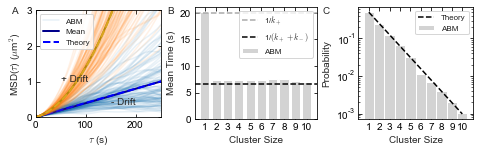

In [17]:
print('Plot Setup')
plot_setup()

if not os.path.isfile('data/ABM_Validation_Data_Processed.pkl'):
    print('Data Processing')
    procdat = data_processing()

    with open('data/ABM_Validation_Data_Processed.pkl','wb') as f:
        pickle.dump(procdat,f)

print('Plotting')
with open('data/ABM_Validation_Data_Processed.pkl','rb') as f:
    procdat = pickle.load(f)

make_plots(procdat)